# Imports

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import yaml
import sys
import os
import re
import json
from tqdm import tqdm
import warnings

from pyspark.sql import functions as F
from pyspark.sql.types import DateType, ArrayType, StringType
from pyspark.sql.functions import udf, broadcast


from optbinning import OptimalBinning, ContinuousOptimalBinning
import category_encoders as ce
from typing import List, Dict
import shap
import lightgbm as lgb
import scipy
from scipy.stats import spearmanr, pearsonr, kendalltau, pointbiserialr, f_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff
import joblib

import numpy as np
from scipy.stats import logistic, norm, trim_mean
from pathlib import Path
from matplotlib.ticker import FuncFormatter

from skopt import gp_minimize
from skopt.space import Real
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.optimize import Bounds
import itertools
import random
from bayes_opt import BayesianOptimization
from bayes_opt.util import UtilityFunction
import time

from joblib import Parallel, delayed
import ast

import statsmodels.api as sm
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# paths and custom modules
cwd_path = Path(os.getcwd())
data_path = cwd_path/'data/'
objects_path = cwd_path/'objects/'
sys.path.append(os.path.dirname(cwd_path))

from utils import *

data_catalog, models_catalog = return_catalog()

# Fetch Data

In [3]:
# fetch data
data_date = '20240810'
income_model_version = 'v0.7'
pd_model_version = 'v0.7'
rule_based_version = 'v0.1'
calculation_center_version = 'v0.2'

# processed all features
df_to_all_models = pd.read_parquet(data_path / f"features_store/{data_date}_L1_processed_features.parquet")
df_to_all_models['mc_estimated_cwf'] =  df_to_all_models['first_ord_dbr'] * df_to_all_models['first_ord_tenor'] # TODO here I define what did MC use for CWF

# income predictions
income_predics = pd.read_parquet(data_path / f'models_preds/{data_date}_income_{income_model_version}_predics.parquet')
income_predics = income_predics.rename(columns={'predics': 'income_predics'})

# pd predictions
pd_predics = pd.read_parquet(data_path / f'models_preds/{data_date}_pd_{pd_model_version}_predics.parquet')
pd_predics = pd_predics.rename(columns={'cali_predics': 'pd_predics'})

# rule-based predictions
rule_based_predics = pd.read_parquet(data_path / f'models_preds/{data_date}_rule_based_{rule_based_version}_predics.parquet')
rule_based_predics = rule_based_predics.rename(columns={'predics_score': 'rule_based_predics_score',
                                                        'predics_pd':'rule_based_predics_pd'})

# calculation center results
cc_results = pd.read_parquet(data_path / f'models_preds/{data_date}_calculation_center_{calculation_center_version}_results.parquet')

# migrated and to be migrated customers credit limits
# cl_migration_df = pd.read_parquet(data_path / f'analytics/{data_date}_cl_migration_df.parquet')
analysis_date = '20241112'
cl_migration_df = pd.read_parquet(data_path / f'analytics/{analysis_date}_cl_migration_df.parquet')

In [4]:
# view all features
print(df_to_all_models.columns,
      '\n',
      income_predics.columns,
      '\n',
      pd_predics.columns,
      '\n',
      rule_based_predics.columns,
      '\n',
      cc_results.columns,
      '\n',
      cl_migration_df.columns)

Index(['client_id', 'ssn', 'phone_number_1', 'phone_number_2',
       'flag_is_mc_customer', 'flag_is_prv_cash_trx', 'flag_is_rescore',
       'job_name_map', 'job_type', 'insurance_type', 'marital_status',
       'children_count', 'address_governorate', 'address_city', 'address_area',
       'house_type', 'mobile_os_type', 'days_since_contract', 'have_car',
       'car_model_category', 'have_club_id', 'ssn_is_male', 'ssn_governorate',
       'age_at_contract', 'net_income_first', 'net_income', 'net_burden',
       'net_income_inflated', 'net_burden_inflated', 'job_map_min_salary',
       'job_map_max_salary', 'is_iscore', 'iscore_score', 'OpenAccounts_count',
       'OpenAccounts_ApprovalAmount_sum',
       'OpenAccounts_ApprovalAmount_sum_pofi',
       'OpenAccounts_BalanceAmount_sum', 'OpenAccounts_BalanceAmount_sum_pofi',
       'OpenAccounts_InstallmentAmount_sum',
       'OpenAccounts_InstallmentAmount_sum_pofi',
       'OpenAccounts_MaxDaysDue_sum', 'ClosedAccounts_count',
     

In [5]:
# Select features and merge
gen_analysis_df = df_to_all_models[['client_id', 'ssn', 'net_income_inflated', 'job_name_map',
                                'net_burden_inflated', 'OpenAccounts_InstallmentAmount_sum', 'fo_par90_flag', 'mc_estimated_cwf']]\
                .merge(cl_migration_df[['client_id', 'is_mylo_migrated', 'mylo_rev18_cl']], how='left', on='client_id')\
                .merge(income_predics, how='left', on='client_id')\
                .merge(pd_predics, how='left', on='client_id')\
                .merge(cc_results, how='left', on='client_id')

gen_analysis_df.columns

Index(['client_id', 'ssn', 'net_income_inflated', 'job_name_map',
       'net_burden_inflated', 'OpenAccounts_InstallmentAmount_sum',
       'fo_par90_flag', 'mc_estimated_cwf', 'is_mylo_migrated',
       'mylo_rev18_cl', 'income_predics', 'pd_predics', 'pd_AR',
       'income_ratio', 'final_income', 'income_zone', 'cwf', 'cwf_segment',
       'final_net_income', 'credit_limit'],
      dtype='object')

# 3- General Analyses

## Adjust CalculationCenter Params [If needed]

In [6]:
# CC params
PD_THRESHOLD = 0.145
GREEN_INCOME_ZONE_THRESHOLD = 0.1
RED_INCOME_ZONE_THRESHOLD = 0.5
FINAL_INCOME_LOGIC = 'all_not_verify' #all_verify #all_not_verify

PD_BINS_TO_CWF = {
    'pd_in': [PD_THRESHOLD, 0.09, 0.045, 0.025, 0.01, 0],
    'cwf_map': [2, 2.5, 3.5, 6, 8],
    'risk_seg_map': ['Tier-5', 'Tier-4', 'Tier-3', 'Tier-2', 'Tier-1']
}

CL_MAX_LIMIT = 500000
CL_MIN_LIMIT = 1000


# apply A/R rule
gen_analysis_df['pd_AR'] = np.where(
    gen_analysis_df['pd_predics'] <= PD_THRESHOLD,
    'accept',
    'reject'
    )


# Get income ratio
gen_analysis_df['income_ratio'] = gen_analysis_df['net_income_inflated'] / gen_analysis_df['income_predics']

# Get final income and zone
gen_analysis_df['final_income'], gen_analysis_df['income_zone'] = calculate_income_zones(gen_analysis_df,
                                                      'net_income_inflated',
                                                      'income_predics',
                                                      blogic= FINAL_INCOME_LOGIC,
                                                      GREEN_INCOME_ZONE_THRESHOLD=GREEN_INCOME_ZONE_THRESHOLD,
                                                      RED_INCOME_ZONE_THRESHOLD=RED_INCOME_ZONE_THRESHOLD)

#TODO I added this stupid code block to compute the verified scenario
gen_analysis_df['final_income_verified'], _ = calculate_income_zones(gen_analysis_df,
                                                      'net_income_inflated',
                                                      'income_predics',
                                                      blogic= 'all_verify',
                                                      GREEN_INCOME_ZONE_THRESHOLD=GREEN_INCOME_ZONE_THRESHOLD,
                                                      RED_INCOME_ZONE_THRESHOLD=RED_INCOME_ZONE_THRESHOLD)

# get cwf and risk segment
gen_analysis_df['cwf'], gen_analysis_df['cwf_segment'] = get_cwf_and_segment(
                            gen_analysis_df['pd_predics'],
                            gen_analysis_df['pd_AR'], 
                            pd_bins_to_cwf=PD_BINS_TO_CWF
                            )

# add reject flag
gen_analysis_df.loc[gen_analysis_df['pd_AR'] == 'reject', 'cwf_segment'] = 'Rejected'

# re-ordering
cat_order = ['Rejected']+PD_BINS_TO_CWF['risk_seg_map']
gen_analysis_df['cwf_segment'] = gen_analysis_df['cwf_segment'].astype('category')
gen_analysis_df['cwf_segment'] = gen_analysis_df['cwf_segment'].cat.reorder_categories(cat_order, ordered=True)


# calculate credit limit
gen_analysis_df['final_net_income'] = gen_analysis_df['final_income'] - (gen_analysis_df['OpenAccounts_InstallmentAmount_sum'].fillna(0) + gen_analysis_df['net_burden_inflated'].fillna(0))
gen_analysis_df['final_net_income'] = gen_analysis_df['final_net_income'].clip(lower=0)
gen_analysis_df['credit_limit'] = round(gen_analysis_df['final_net_income'] * gen_analysis_df['cwf'], 0)


#TODO I added this stupid code block to compute the verified scenario
gen_analysis_df['final_net_income_verified'] = gen_analysis_df['final_income_verified'] - (gen_analysis_df['OpenAccounts_InstallmentAmount_sum'].fillna(0) + gen_analysis_df['net_burden_inflated'].fillna(0))
gen_analysis_df['final_net_income_verified'] = gen_analysis_df['final_net_income_verified'].clip(lower=0)
gen_analysis_df['credit_limit_verified'] = round(gen_analysis_df['final_net_income_verified'] * gen_analysis_df['cwf'], 0)

## CL Distribution

In [7]:
# expected credit loss
gen_analysis_df['ECL'] = round(gen_analysis_df['credit_limit']*gen_analysis_df['pd_predics'], 0)

# Define bins and labels for the income zones
bins = [-float('inf'), 5000, 10000, 15000,30000, float('inf')]
labels = ['A. <5K', 'B. 5K-10K', 'C. 10K-15K','D. 15K-30K', 'E. >30K']
gen_analysis_df['final_income_segment'] = pd.cut(gen_analysis_df['final_income'], bins=bins, labels=labels, right=False)

# Use observed=True to only group by the levels that are present in the data
segments_df = gen_analysis_df.groupby('cwf_segment', observed=True).agg({
    'client_id': [('count', 'count'), ('proportion', lambda x: len(x) / len(gen_analysis_df))],
    'pd_predics': ['mean'],
    'fo_par90_flag': ['mean'],
    'final_net_income': ['mean'],
    'cwf': ['mean'],
    'credit_limit': ['mean'],
    'ECL': ['mean']
})

# Apply rounding to the aggregated DataFrame (round to 2 decimal places)
segments_df = segments_df.round(2)
print('Median CL = ',gen_analysis_df['credit_limit'].median())
segments_df

Median CL =  47366.0


client_id            pd_predics fo_par90_flag final_net_income  \
                count proportion       mean          mean             mean   
cwf_segment                                                                  
Rejected       114676       0.14       0.30          0.30          5994.46   
Tier-5          61007       0.08       0.12          0.12          6324.57   
Tier-4          83625       0.11       0.07          0.07          7348.62   
Tier-3         109471       0.14       0.03          0.03          8096.18   
Tier-2         135973       0.17       0.02          0.02          8302.99   
Tier-1         288813       0.36       0.01          0.01          8388.67   

             cwf credit_limit      ECL  
            mean         mean     mean  
cwf_segment                             
Rejected     2.0      8440.58  8440.58  
Tier-5       2.0     12649.15  1529.01  
Tier-4       2.5     18371.54  1224.92  
Tier-3       3.5     28336.62   932.64  
Tier-2       6.0     49817.94   793.11  
Tier-1       8.0     67109.40   352.30

In [8]:
unique_segments = gen_analysis_df['cwf_segment'].unique()
palette = sns.color_palette("husl", len(unique_segments))
segment_color_mapping = {segment: color for segment, color in zip(unique_segments, palette)}

def plot_graphs(df, plot_type, ax, title, label_type='percentage', **kwargs):
    if plot_type == 'combined_count_percentage':
        counts = df['cwf_segment'].value_counts().rename('counts')
        percentages = df['cwf_segment'].value_counts(normalize=True).rename('percentage') * 100
        combined_data = pd.concat([counts, percentages], axis=1).reset_index()
        combined_data.columns = ['cwf_segment', 'counts', 'percentage']
        combined_data['cwf_segment'] = pd.Categorical(combined_data['cwf_segment'], categories=unique_segments, ordered=True)
        combined_data = combined_data.sort_values('cwf_segment')
        
        # Fixing the hue issue with palette
        sns.barplot(data=combined_data, x='cwf_segment', y='counts', hue='cwf_segment', palette=segment_color_mapping, ax=ax, legend=False)
        for p, percentage, count in zip(ax.patches, combined_data['percentage'], combined_data['counts']):
            height = p.get_height()
            label = f'{percentage:.1f}%' if label_type == 'percentage' else f'{count}'
            ax.annotate(label, (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    elif plot_type == 'barplot':
        sns.barplot(data=df, x='cwf_segment', y=kwargs['y'], hue='cwf_segment', palette=segment_color_mapping, ax=ax, legend=False)
        
        # Fixing the pandas observed warning
        percentages = df.groupby('cwf_segment', observed=True)[kwargs['y']].mean().rename('percentage') * 100
        for p, percentage in zip(ax.patches, percentages):
            height = p.get_height()
            label = f'{percentage:.1f}%' if label_type == 'percentage' else f'{height:.1f}'
            ax.annotate(label, (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    elif plot_type == 'sum_data':
        sum_data = df.groupby('cwf_segment', observed=True)[kwargs['y']].sum().reset_index()
        sum_data[kwargs['new_col']] = sum_data[kwargs['y']] / kwargs['divisor']
        
        # Fixing the hue issue with palette
        sns.barplot(data=sum_data, x='cwf_segment', y=kwargs['new_col'], hue='cwf_segment', palette=segment_color_mapping, ax=ax, legend=False)
        total_sum = sum_data[kwargs['new_col']].sum()
        percentages = (sum_data[kwargs['new_col']] / total_sum) * 100
        for p, percentage in zip(ax.patches, percentages):
            height = p.get_height()
            label = f'{percentage:.1f}%' if label_type == 'percentage' else f'{height:.1f}'
            ax.annotate(label, (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    ax.set_xlabel(kwargs.get('xlabel', 'Risk Segment'))
    ax.set_ylabel(kwargs.get('ylabel', ''))
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    ax.set_title(title)

def draw_beautiful_histogram(data, column, categorical_column, bin_width=10000, max_limit=150000, ax=None, title='', label_type='percentage'):
    filtered_data = data[data[column] <= max_limit]
    min_value = filtered_data[column].min()
    max_value = filtered_data[column].max()
    bin_edges = np.arange(start=min_value - (min_value % bin_width), stop=max_value + bin_width, step=bin_width)
    non_empty_categories = filtered_data[categorical_column].dropna().unique()
    non_empty_categories_sorted = sorted(non_empty_categories)
    
    # Fixing the hue and palette
    sns.histplot(data=filtered_data, x=column, hue=categorical_column, bins=bin_edges, stat='count', multiple='stack', palette='tab10', element='bars', legend=True, hue_order=non_empty_categories_sorted, ax=ax)
    
    mean_value = filtered_data[column].mean()
    ax.axvline(mean_value, color='red', linestyle='--')
    ax.text(mean_value, ax.get_ylim()[1] * 0.95, f'Mean: {mean_value/1000:.0f}K', color='red', ha='right')
    ax.set_xlabel(column, fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    tick_values = np.arange(start=min_value - (min_value % bin_width), stop=max_value + bin_width, step=bin_width)
    ax.set_xticks(tick_values)
    ax.set_xticklabels([f'{int(x/1000)}K' for x in tick_values])
    ax.set_title(f'{title}', fontsize=16)
    
    # Calculate and annotate percentages
    total_count = len(filtered_data)
    bin_counts, _ = np.histogram(filtered_data[column], bins=bin_edges)
    for i, count in enumerate(bin_counts):
        percentage = (count / total_count) * 100
        bin_center = (bin_edges[i] + bin_edges[i + 1]) / 2
        label = f'{percentage:.1f}%' if label_type == 'percentage' else f'{count}'
        ax.annotate(label, (bin_center, count), 
                    ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

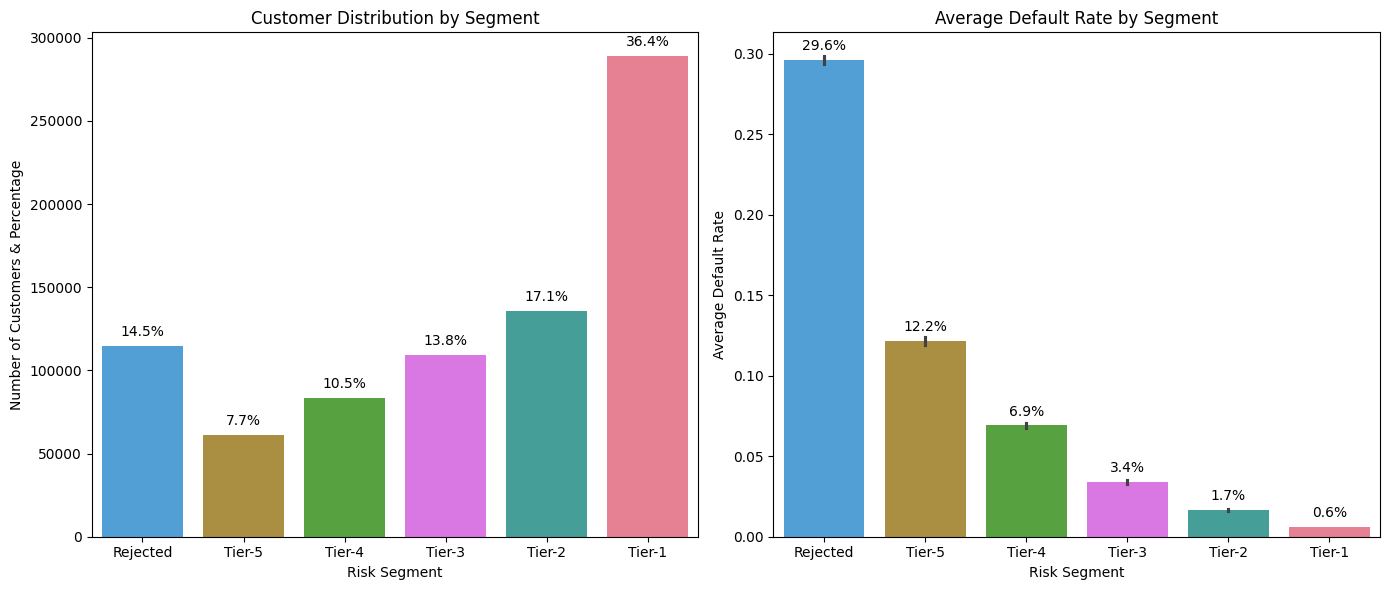

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
plot_graphs(gen_analysis_df, 'combined_count_percentage', axs[0], 'Customer Distribution by Segment', ylabel='Number of Customers & Percentage')
plot_graphs(gen_analysis_df, 'barplot', axs[1], 'Average Default Rate by Segment', y='fo_par90_flag', ylabel='Average Default Rate')

plt.tight_layout()
plt.show()

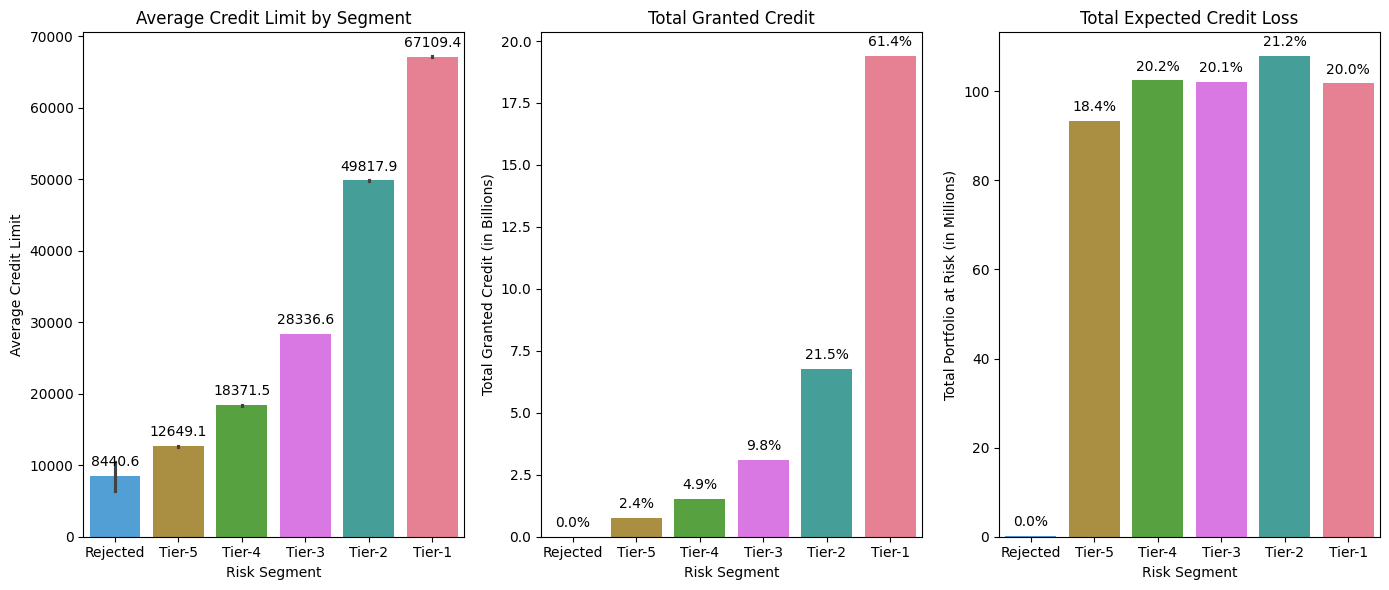

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))
plot_graphs(gen_analysis_df, 'barplot', axs[0], 'Average Credit Limit by Segment', y='credit_limit', ylabel='Average Credit Limit', label_type='else')
plot_graphs(gen_analysis_df, 'sum_data', axs[1], 'Total Granted Credit', y='credit_limit', new_col='credit_limit_mil', divisor=1e9, ylabel='Total Granted Credit (in Billions)')
plot_graphs(gen_analysis_df, 'sum_data', axs[2], 'Total Expected Credit Loss', y='ECL', new_col='ECL_mil', divisor=1e6, ylabel='Total Portfolio at Risk (in Millions)')

plt.tight_layout()
plt.show()

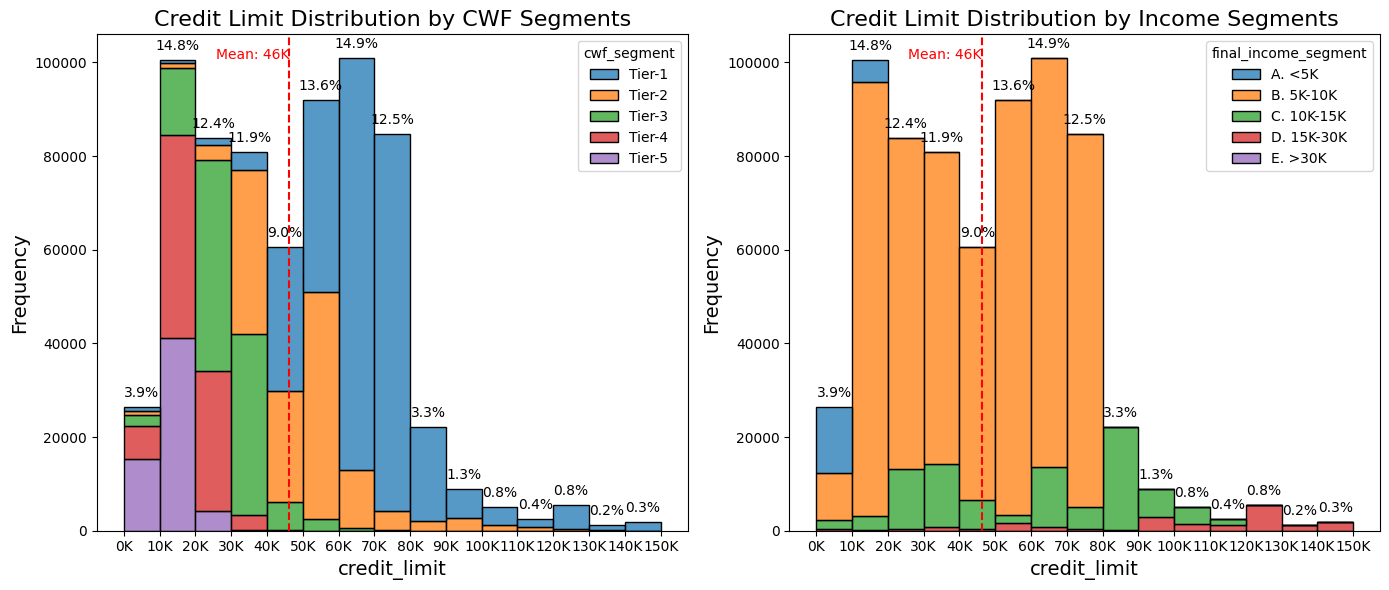

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
draw_beautiful_histogram(data=gen_analysis_df.query('pd_AR == "accept"'),
                         column='credit_limit',
                         categorical_column='cwf_segment',
                         bin_width=10000,
                         ax=axs[0],
                         title='Credit Limit Distribution by CWF Segments')

draw_beautiful_histogram(data=gen_analysis_df.query('pd_AR == "accept"'),
                         column='credit_limit',
                         categorical_column='final_income_segment',
                         bin_width=10000,
                         ax=axs[1],
                         title='Credit Limit Distribution by Income Segments')

plt.tight_layout()
plt.show()

## Income Model Analysis

In [12]:
def style_dataframe(cmap='viridis', precision=3):
    """
    Returns a styling function that can be used in a DataFrame pipe to apply gradient-based conditional formatting 
    to all numeric columns.
    
    Parameters:
    - cmap (str): Color map for gradient, default is 'viridis'.
    - precision (int): Decimal places to round to, default is 2.
    
    Returns:
    - function: A function to style a DataFrame, designed to be used with .pipe()
    """
    def _style(df):
        numeric_columns = df.select_dtypes(include=[float, int]).columns  # Automatically select numeric columns
        return (df.style
                .background_gradient(subset=numeric_columns, cmap=cmap)  # Apply color map to all numeric columns
                .format(precision=precision))  # Set rounding precision for display
    return _style

In [13]:
# Setup
extract_to_csv = False
run_only_on_is_migrated = True

mylo_df = gen_analysis_df[gen_analysis_df['is_mylo_migrated'] == True].reset_index(drop=True)
mylo_df.columns

Index(['client_id', 'ssn', 'net_income_inflated', 'job_name_map',
       'net_burden_inflated', 'OpenAccounts_InstallmentAmount_sum',
       'fo_par90_flag', 'mc_estimated_cwf', 'is_mylo_migrated',
       'mylo_rev18_cl', 'income_predics', 'pd_predics', 'pd_AR',
       'income_ratio', 'final_income', 'income_zone', 'cwf', 'cwf_segment',
       'final_net_income', 'credit_limit', 'final_income_verified',
       'final_net_income_verified', 'credit_limit_verified', 'ECL',
       'final_income_segment'],
      dtype='object')

In [14]:
print(f'Count of mylo customers included:', mylo_df.shape[0])
print(f'Average stated income:', mylo_df['net_income_inflated'].mean().astype(int))
print(f'Average predicted income:', mylo_df['income_predics'].mean().astype(int))
print(f'Average to-be-granted CL:', mylo_df['credit_limit'].mean().astype(int))
print(f'Average to-be-granted CL after verification:', mylo_df['credit_limit_verified'].mean().astype(int))
print(f'Average Actual CL with 6x logic:', mylo_df['mylo_rev18_cl'].mean().astype(int))

Count of mylo customers included: 7446
Average stated income: 10094
Average predicted income: 9143
Average to-be-granted CL: 51504
Average to-be-granted CL after verification: 57895
Average Actual CL with 6x logic: 61872


In [15]:
mylo_df.groupby('income_zone').agg(
    count=('income_zone', 'size'),
    percentage=('job_name_map', lambda x: (len(x) / len(mylo_df)) * 100),
    avg_stated_income=('net_income_inflated', 'mean'),
    avg_predicted_income=('income_predics', 'mean'),
    avg_pd=('pd_predics', 'mean'),
    avg_cwf=('cwf', 'mean'),
    avg_credit_limit=('credit_limit', 'mean'),
    avg_credit_limit_verified=('credit_limit_verified', 'mean'),
).reset_index().sort_values(by='percentage', ascending=False).pipe(style_dataframe())

,income_zone,count,percentage,avg_stated_income,avg_predicted_income,avg_pd,avg_cwf,avg_credit_limit,avg_credit_limit_verified
0,Green Zone,5236,70.320,8063.717,9198.353,0.041,6.465,51864.346,51864.346
2,Yellow Zone,1347,18.090,11399.651,9002.992,0.040,5.665,50460.625,64429.435
1,Red Zone,863,11.590,20374.865,9027.000,0.045,5.647,51014.690,83460.736


In [16]:
mylo_df.groupby('job_name_map').agg(
    count=('job_name_map', 'size'),
    percentage=('job_name_map', lambda x: (len(x) / len(mylo_df)) * 100),
    avg_stated_income=('net_income_inflated', 'mean'),
    avg_predicted_income=('income_predics', 'mean'),
    avg_pd=('pd_predics', 'mean'),
    avg_cwf=('cwf', 'mean'),
    avg_credit_limit=('credit_limit', 'mean'),
    avg_credit_limit_verified=('credit_limit_verified', 'mean'),
    # Add zone-specific shares, calculating within each group
    green_zone_share=('income_zone', lambda x: (x.eq('Green Zone').sum() / len(x)) * 100),
    yellow_zone_share=('income_zone', lambda x: (x.eq('Yellow Zone').sum() / len(x)) * 100),
    red_zone_share=('income_zone', lambda x: (x.eq('Red Zone').sum() / len(x)) * 100)
).reset_index().sort_values(by='percentage', ascending=False).pipe(style_dataframe())

,job_name_map,count,percentage,avg_stated_income,avg_predicted_income,avg_pd,avg_cwf,avg_credit_limit,avg_credit_limit_verified,green_zone_share,yellow_zone_share,red_zone_share
8,other-employed,4360,58.555,10138.112,9227.897,0.038,6.333,53638.087,59698.906,71.009,18.945,10.046
9,other-freelancer,852,11.442,8411.425,7402.729,0.082,5.745,37124.173,40678.171,73.592,13.028,13.380
11,retired,722,9.696,7538.137,6374.125,0.036,5.704,30462.493,37179.523,62.188,19.391,18.421
14,teaching,612,8.219,11503.301,10516.171,0.015,7.338,66799.734,77178.845,66.830,18.791,14.379
3,governmental-employee,345,4.633,8571.620,8153.692,0.016,6.407,46658.246,50635.925,71.884,23.478,4.638
4,healthcare,166,2.229,18111.139,17986.548,0.011,7.139,106363.693,118107.596,77.711,10.241,12.048
0,business-owner,158,2.122,15347.595,13135.034,0.115,3.309,37940.652,47937.130,74.051,13.924,12.025
1,engineer,93,1.249,14888.839,14887.026,0.017,6.253,77341.333,87644.226,74.194,17.204,8.602
13,student,65,0.873,7267.600,3748.618,0.127,2.290,7264.820,11158.320,61.538,7.692,30.769
10,police-officer,34,0.457,13286.500,12668.068,0.049,3.941,45327.706,51090.176,73.529,17.647,8.824


In [17]:
mylo_df.groupby('cwf_segment').agg(
    count=('cwf_segment', 'size'),
    percentage=('cwf_segment', lambda x: (len(x) / len(mylo_df)) * 100),
    avg_stated_income=('net_income_inflated', 'mean'),
    avg_predicted_income=('income_predics', 'mean'),
    avg_pd=('pd_predics', 'mean'),
    avg_cwf=('cwf', 'mean'),
    avg_credit_limit=('credit_limit', 'mean'),
    avg_credit_limit_verified=('credit_limit_verified', 'mean'),
    # Add zone-specific shares, calculating within each group
    green_zone_share=('income_zone', lambda x: (x.eq('Green Zone').sum() / len(x)) * 100),
    yellow_zone_share=('income_zone', lambda x: (x.eq('Yellow Zone').sum() / len(x)) * 100),
    red_zone_share=('income_zone', lambda x: (x.eq('Red Zone').sum() / len(x)) * 100)
).reset_index().sort_values(by='cwf_segment', ascending=False).pipe(style_dataframe())

,cwf_segment,count,percentage,avg_stated_income,avg_predicted_income,avg_pd,avg_cwf,avg_credit_limit,avg_credit_limit_verified,green_zone_share,yellow_zone_share,red_zone_share
5,Tier-1,3712,49.852,10054.564,9473.009,0.005,8.000,67719.115,74717.979,77.155,13.874,8.971
4,Tier-2,1272,17.083,10638.198,9112.355,0.016,6.000,49385.954,57255.905,63.522,23.113,13.365
3,Tier-3,923,12.396,10785.255,8897.819,0.033,3.500,26652.653,32057.276,60.563,24.485,14.951
2,Tier-4,613,8.233,10504.652,8842.457,0.067,2.500,17964.302,21489.131,57.749,24.470,17.781
1,Tier-5,363,4.875,9296.557,8288.076,0.119,2.000,12947.975,15289.950,59.229,25.344,15.427
0,Rejected,563,7.561,8059.217,8318.820,0.280,nan,nan,nan,77.442,12.433,10.124


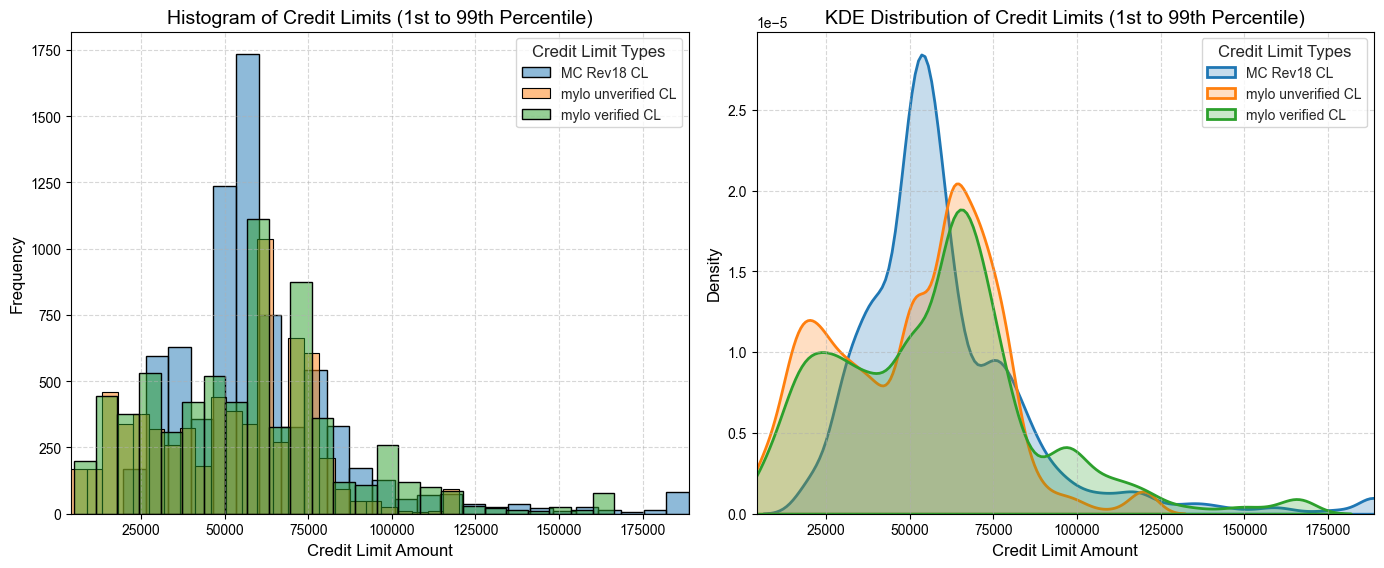

In [18]:
# Copying the DataFrame
df = mylo_df.copy()
columns = ['mylo_rev18_cl', 'credit_limit', 'credit_limit_verified']

column_aliases = {
    'mylo_rev18_cl': 'MC Rev18 CL',
    'credit_limit': 'mylo unverified CL',
    'credit_limit_verified': 'mylo verified CL'
}
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Apply percentile clipping to focus on the core data range
lower_percentile = 0.01
upper_percentile = 0.99
df_clipped = df[columns].apply(lambda x: x.clip(x.quantile(lower_percentile), x.quantile(upper_percentile)))

# Set up the figure with histogram first, KDE second
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=100)
sns.set(style="whitegrid")

# Histogram Plot (left subplot)
for col, color in zip(columns, colors):
    sns.histplot(df_clipped[col], ax=ax1, bins=25, color=color, kde=False, label=column_aliases[col], edgecolor='black', alpha=0.5)

ax1.set_title('Histogram of Credit Limits (1st to 99th Percentile)', fontsize=14)
ax1.set_xlabel('Credit Limit Amount', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.legend(title='Credit Limit Types', fontsize=10)  # Add legend
ax1.grid(True, linestyle='--', alpha=0.5)

# KDE Plot (right subplot)
for col, color in zip(columns, colors):
    sns.kdeplot(df_clipped[col], ax=ax2, fill=True, linewidth=2, color=color, label=column_aliases[col])

ax2.set_title('KDE Distribution of Credit Limits (1st to 99th Percentile)', fontsize=14)
ax2.set_xlabel('Credit Limit Amount', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.legend(title='Credit Limit Types', fontsize=10)  # Add legend
ax2.grid(True, linestyle='--', alpha=0.5)

# Ensure x-axis limits are synchronized across both plots
x_min, x_max = df_clipped.min().min(), df_clipped.max().max()
ax1.set_xlim(x_min, x_max)
ax2.set_xlim(x_min, x_max)

plt.tight_layout()
plt.show()

## CL Comparison with MC

In [19]:
# Setup
extract_to_csv = False
run_only_on_is_migrated = False

In [20]:
# export
if extract_to_csv:
    path=Path('C:/Users/amr.tawfik/Documents/GitHub/mylo/components/risk-engine/AT_references')
    gen_analysis_df_clean = gen_analysis_df.round(5)
    gen_analysis_df_clean.to_csv(path/f'Others/{data_date}_CL_analysis_raw.csv', index=False)
    print('CSV data was extracted successfully')

# filter
if run_only_on_is_migrated:
    print('running only on mylo migrated customers')
    filtered_df = gen_analysis_df[gen_analysis_df['is_mylo_migrated'] == True]
else:
    print('running on all custommers')
    filtered_df = gen_analysis_df.copy()

# Initial number of rows
initial_length = len(filtered_df)

# Step 1: Filter out rows where pd_AR = 'accept'
filtered_df = filtered_df[filtered_df['pd_AR'] == 'accept']
length_after_pd_AR_filter = len(filtered_df)
pd_AR_dropped = initial_length - length_after_pd_AR_filter
pd_AR_dropped_percentage = (pd_AR_dropped / initial_length) * 100

print(f"Initial number of rows: {initial_length}")
print(f"Number of rows after pd_AR filter: {length_after_pd_AR_filter}")
print(f"Rows dropped due to pd_AR = 'reject': {pd_AR_dropped} ({pd_AR_dropped_percentage:.2f}%)")

# Rename columns for consistency
filtered_df = filtered_df.rename(columns={'credit_limit': 'mylo_riskengine_cl'})

# Step 2: Filter out rows with NaN or 0 values in mylo_riskengine_cl
length_before_mylo_riskengine_cl_filter = len(filtered_df)
filtered_df = filtered_df.dropna(subset=['mylo_riskengine_cl'])
filtered_df = filtered_df[filtered_df['mylo_riskengine_cl'] > 0]
length_after_mylo_riskengine_cl_filter = len(filtered_df)
mylo_riskengine_cl_na_zero_dropped = length_before_mylo_riskengine_cl_filter - length_after_mylo_riskengine_cl_filter
mylo_riskengine_cl_na_zero_dropped_percentage = (mylo_riskengine_cl_na_zero_dropped / length_before_mylo_riskengine_cl_filter) * 100

print(f"\nNumber of rows after mylo_riskengine_cl filter (NaN and 0): {length_after_mylo_riskengine_cl_filter}")
print(f"Rows dropped due to NaNs or 0s in mylo_riskengine_cl: {mylo_riskengine_cl_na_zero_dropped} ({mylo_riskengine_cl_na_zero_dropped_percentage:.2f}%)")

# Step 3: Filter out rows with NaN or 0 values in mylo_rev18_cl
length_before_mylo_rev18_cl_filter = len(filtered_df)
filtered_df = filtered_df.dropna(subset=['mylo_rev18_cl'])
filtered_df = filtered_df[filtered_df['mylo_rev18_cl'] > 0]
length_after_mylo_rev18_cl_filter = len(filtered_df)
mylo_rev18_cl_na_zero_dropped = length_before_mylo_rev18_cl_filter - length_after_mylo_rev18_cl_filter
mylo_rev18_cl_na_zero_dropped_percentage = (mylo_rev18_cl_na_zero_dropped / length_before_mylo_rev18_cl_filter) * 100

print(f"\nNumber of rows after mylo_rev18_cl filter (NaN and 0): {length_after_mylo_rev18_cl_filter}")
print(f"Rows dropped due to NaNs or 0s in mylo_rev18_cl: {mylo_rev18_cl_na_zero_dropped} ({mylo_rev18_cl_na_zero_dropped_percentage:.2f}%)")

# Cleaned data
cleaned_length = len(filtered_df)
total_dropped = initial_length - cleaned_length
total_dropped_percentage = (total_dropped / initial_length) * 100

print(f"\nFinal number of rows after all filters: {cleaned_length}")
print(f"Total rows dropped: {total_dropped} ({total_dropped_percentage:.2f}%)")

# Extract cleaned columns
mylo_riskengine_cl_clean = filtered_df['mylo_riskengine_cl']
mylo_rev18_cl_clean = filtered_df['mylo_rev18_cl']

running on all custommers
Initial number of rows: 793565
Number of rows after pd_AR filter: 678889
Rows dropped due to pd_AR = 'reject': 114676 (14.45%)

Number of rows after mylo_riskengine_cl filter (NaN and 0): 674807
Rows dropped due to NaNs or 0s in mylo_riskengine_cl: 4082 (0.60%)

Number of rows after mylo_rev18_cl filter (NaN and 0): 619471
Rows dropped due to NaNs or 0s in mylo_rev18_cl: 55336 (8.20%)

Final number of rows after all filters: 619471
Total rows dropped: 174094 (21.94%)


In [21]:
# Descriptive Statistics
mylo_riskengine_cl_stats = round(mylo_riskengine_cl_clean.describe(), 0)
mylo_rev18_cl_stats = round(mylo_rev18_cl_clean.describe(), 0)

print("\nmylo_riskengine_cl Descriptive Statistics:")
print(mylo_riskengine_cl_stats)
print("\nmylo_rev18_cl Descriptive Statistics:")
print(mylo_rev18_cl_stats)


mylo_riskengine_cl Descriptive Statistics:
count    619471.0
mean      48253.0
std       25565.0
min           2.0
25%       26276.0
50%       50000.0
75%       66600.0
max      242449.0
Name: mylo_riskengine_cl, dtype: float64

mylo_rev18_cl Descriptive Statistics:
count     619471.0
mean       59712.0
std        35640.0
min           18.0
25%        39375.0
50%        54283.0
75%        66938.0
max      4720275.0
Name: mylo_rev18_cl, dtype: float64


In [22]:
# Define new bins and labels
bins = [0, 20000, 40000, 60000, 80000, 100000, 150000, 200000, np.inf]
labels = ['<20K', '20-40K', '40-60K', '60-80K', '80-100K', '100-150K', '150-200K', '>200K']

# Create bin categories for both variables
filtered_df['mylo_riskengine_cl_bins'] = pd.cut(mylo_riskengine_cl_clean, bins=bins, labels=labels)
filtered_df['mylo_rev18_cl_bins'] = pd.cut(mylo_rev18_cl_clean, bins=bins, labels=labels)

# Calculate counts and percentages
mylo_riskengine_cl_bin_counts = filtered_df['mylo_riskengine_cl_bins'].value_counts().sort_index()
mylo_rev18_cl_bin_counts = filtered_df['mylo_rev18_cl_bins'].value_counts().sort_index()

total_counts = len(filtered_df)
mylo_riskengine_cl_bin_percentages = round((mylo_riskengine_cl_bin_counts / total_counts) * 100, 1)
mylo_rev18_cl_bin_percentages = round((mylo_rev18_cl_bin_counts / total_counts) * 100, 1)

# Combine counts and percentages
mylo_riskengine_cl_summary = mylo_riskengine_cl_bin_counts.astype(str) + ' (' + mylo_riskengine_cl_bin_percentages.astype(str) + '%)'
mylo_rev18_cl_summary = mylo_rev18_cl_bin_counts.astype(str) + ' (' + mylo_rev18_cl_bin_percentages.astype(str) + '%)'

# Create a DataFrame for the bin summary
bin_summary = pd.DataFrame({
    'mylo_riskengine_cl': mylo_riskengine_cl_summary,
    'mylo_rev18_cl': mylo_rev18_cl_summary
})
bin_summary.index.name = 'Credit Limit Range'
bin_summary.columns = ['Mylo Risk Engine CL (Count, %)', 'Mylo Rev18 CL (Count, %)']

# Display the bin summary
print("\nBin Summary:")
bin_summary


Bin Summary:


,"Mylo Risk Engine CL (Count, %)","Mylo Rev18 CL (Count, %)"
Credit Limit Range,,
<20K,99925 (16.1%),18450 (3.0%)
20-40K,165008 (26.6%),142020 (22.9%)
40-60K,135090 (21.8%),249347 (40.3%)
60-80K,174934 (28.2%),118646 (19.2%)
80-100K,29409 (4.7%),49501 (8.0%)
100-150K,13602 (2.2%),24373 (3.9%)
150-200K,1475 (0.2%),11036 (1.8%)
>200K,28 (0.0%),6098 (1.0%)


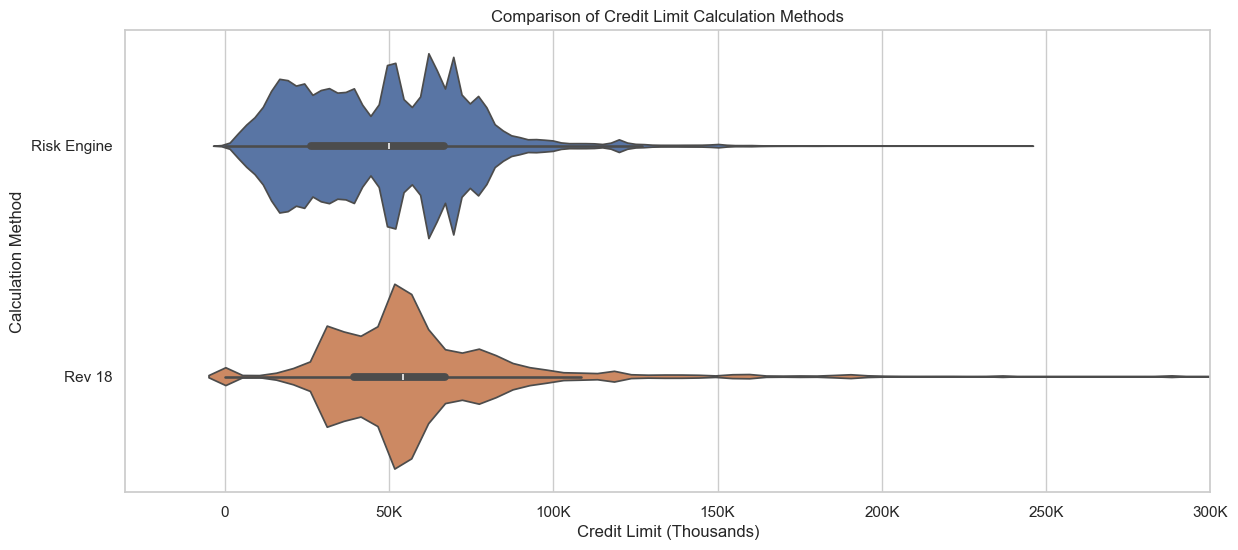

In [23]:
# Remove outliers: values below zero and above 500K
mylo_riskengine_cl_clean = mylo_riskengine_cl_clean[(mylo_riskengine_cl_clean >= 0) & (mylo_riskengine_cl_clean <= 500000)]
mylo_rev18_cl_clean = mylo_rev18_cl_clean[(mylo_rev18_cl_clean >= 0) & (mylo_rev18_cl_clean <= 500000)]

# Assuming your series are named 'credit_limit_method1' and 'credit_limit_method2'
data = pd.DataFrame({'Risk Engine': mylo_riskengine_cl_clean, 'Rev 18': mylo_rev18_cl_clean})

plt.figure(figsize=(14, 6))

def thousands_formatter(x, pos):
    if x >= 1000:
        return f"{x // 1000:.0f}K"
    else:
        return f"{x:.0f}"

sns.violinplot(data=data, orient='h')

plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))

plt.xlabel('Credit Limit (Thousands)')
plt.ylabel('Calculation Method')
plt.title('Comparison of Credit Limit Calculation Methods')
xmin, xmax = plt.xlim()
plt.xlim(xmin, 300000)
plt.show()

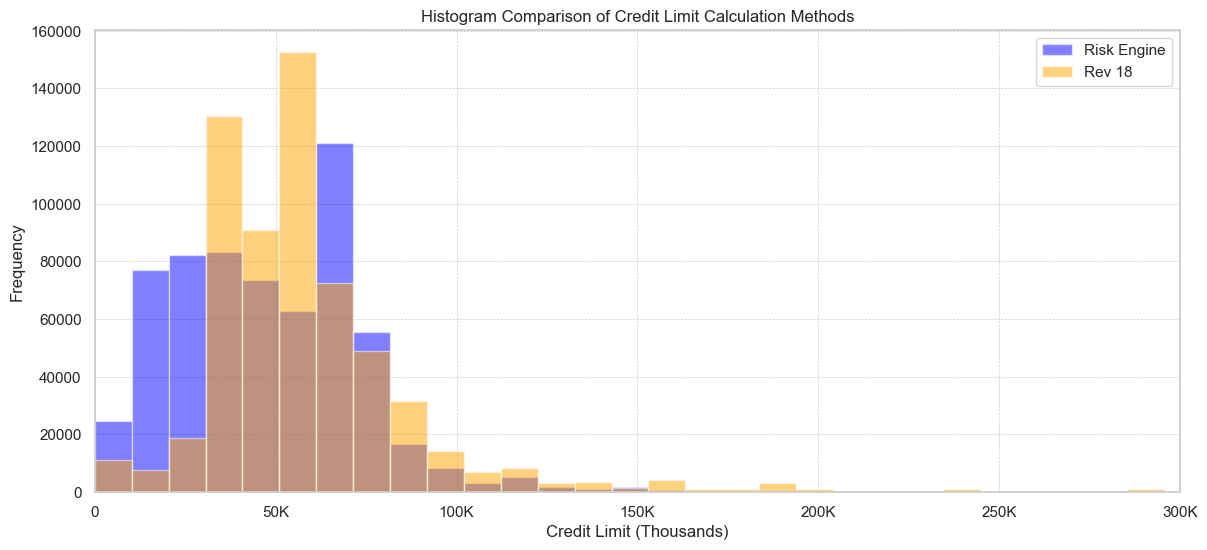

In [24]:
plt.figure(figsize=(14, 6))

def thousands_formatter(x, pos):
    if x >= 1000:
        return f"{x // 1000:.0f}K"
    else:
        return f"{x:.0f}"

# Plot histograms
bins = np.linspace(0, 500000, 50)  # Adjust bins to your liking

plt.hist(mylo_riskengine_cl_clean, bins=bins, alpha=0.5, label='Risk Engine', color='blue')
plt.hist(mylo_rev18_cl_clean, bins=bins, alpha=0.5, label='Rev 18', color='orange')

plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))

plt.xlabel('Credit Limit (Thousands)')
plt.ylabel('Frequency')
plt.title('Histogram Comparison of Credit Limit Calculation Methods')
plt.xlim(0, 300000)

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# 4- RE's Parameters' Tunning

In [25]:
# Intro
opt_analysis_df = gen_analysis_df[['ssn', 'fo_par90_flag','final_net_income', 'pd_predics', 'mc_estimated_cwf']].reset_index(drop=True)
opt_analysis_df['pd_predics'] = opt_analysis_df['pd_predics'].round(5)


## MC Reference Points

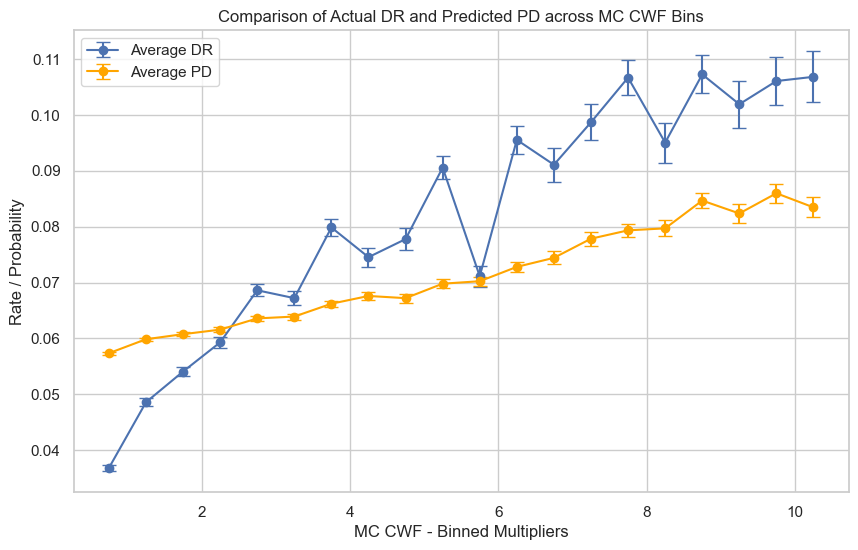

In [26]:
# Step 2: Remove outliers using IQR logic to clean up the data
Q1_cl = opt_analysis_df['mc_estimated_cwf'].quantile(0.25)
Q3_cl = opt_analysis_df['mc_estimated_cwf'].quantile(0.75)
IQR_cl = Q3_cl - Q1_cl

lower_bound_cl = Q1_cl - 1.5 * IQR_cl
upper_bound_cl = Q3_cl + 1.5 * IQR_cl

filtered_df = opt_analysis_df[
    (opt_analysis_df['mc_estimated_cwf'] >= lower_bound_cl) & 
    (opt_analysis_df['mc_estimated_cwf'] <= upper_bound_cl)
]

# Step 3: Generate bins with a step size of 0.5
bin_edges = np.arange(0.5, filtered_df['mc_estimated_cwf'].max() + 0.5, 0.5)
filtered_df['mc_CWF_bin'] = pd.cut(filtered_df['mc_estimated_cwf'], bins=bin_edges)

# Step 4: Calculate summary statistics for each bin
bin_summary = filtered_df.groupby('mc_CWF_bin').agg(
    avg_dr=('fo_par90_flag', 'mean'),
    avg_pd=('pd_predics', 'mean'),
    count=('fo_par90_flag', 'count'),
    std_dr=('fo_par90_flag', 'std'),
    std_pd=('pd_predics', 'std')
).reset_index()

# Calculate the midpoint of each bin for plotting
bin_summary['bin_mid'] = bin_summary['mc_CWF_bin'].apply(lambda x: (x.left + x.right) / 2)
bin_summary['se_dr'] = bin_summary['std_dr'] / np.sqrt(bin_summary['count'])  # Standard Error for DR
bin_summary['se_pd'] = bin_summary['std_pd'] / np.sqrt(bin_summary['count'])  # Standard Error for PD

# Step 5: Plot the relationship between DR and PD across bins
plt.figure(figsize=(10, 6))

# Plot Average Default Rate (DR) with error bars
plt.errorbar(bin_summary['bin_mid'], bin_summary['avg_dr'], 
             yerr=bin_summary['se_dr'], fmt='-o', capsize=5, label='Average DR')

# Plot Predicted Probability of Default (PD) with error bars
plt.errorbar(bin_summary['bin_mid'], bin_summary['avg_pd'], 
             yerr=bin_summary['se_pd'], fmt='-o', capsize=5, label='Average PD', color='orange')

# Customize plot settings
plt.xlabel('MC CWF - Binned Multipliers')
plt.ylabel('Rate / Probability')
plt.title('Comparison of Actual DR and Predicted PD across MC CWF Bins')
plt.grid(True)
plt.legend()

# Display the plot
plt.show()

                            OLS Regression Results                            
Dep. Variable:                 avg_dr   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     152.5
Date:                Sat, 16 Nov 2024   Prob (F-statistic):           3.18e-10
Time:                        22:26:26   Log-Likelihood:                 71.549
No. Observations:                  20   AIC:                            -139.1
Df Residuals:                      18   BIC:                            -137.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0443      0.003     12.910      0.0

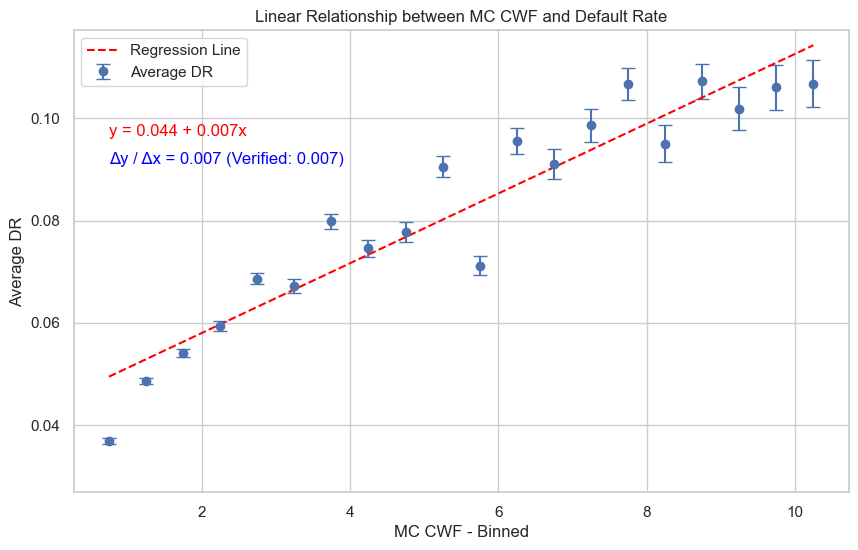

In [27]:
# Step 1: Prepare data for regression (use bin_mid as the predictor)
X = sm.add_constant(bin_summary['bin_mid'])  # Add constant for intercept
y = bin_summary['avg_dr']

# Step 2: Fit a linear regression model
model = sm.OLS(y, X).fit()

# Step 3: Display the regression results
print(model.summary())

# Extract slope and intercept from the model parameters
intercept, slope = model.params

# Calculate two predicted values for manual slope verification
x1, x2 = bin_summary['bin_mid'].min(), bin_summary['bin_mid'].max()
y1, y2 = model.predict([1, x1]), model.predict([1, x2])
manual_slope = (y2 - y1) / (x2 - x1)

print(f"Intercept: {intercept:.3f}, Slope: {slope:.3f}")
print(f"Manual Slope between x1={x1} and x2={x2}: {manual_slope[0]:.3f}")

# Step 4: Plot the regression line on top of the original data
plt.figure(figsize=(10, 6))
plt.errorbar(bin_summary['bin_mid'], bin_summary['avg_dr'], 
             yerr=bin_summary['se_dr'], fmt='o', capsize=5, label='Average DR')

# Align predicted points with the actual bin_mid values for better visualization
predicted_y = model.predict(X)
plt.plot(bin_summary['bin_mid'], predicted_y, linestyle='--', color='red', label='Regression Line')

# Annotate the equation and rate of change (Δy / Δx) on the plot
equation_text = f"y = {intercept:.3f} + {slope:.3f}x"
delta_text = f"Δy / Δx = {slope:.3f} (Verified: {manual_slope[0]:.3f})"
plt.text(bin_summary['bin_mid'].min(), bin_summary['avg_dr'].max() * 0.9, 
         equation_text, fontsize=12, color='red')
plt.text(bin_summary['bin_mid'].min(), bin_summary['avg_dr'].max() * 0.85, 
         delta_text, fontsize=12, color='blue')

# Adjust y-axis limits to highlight small changes in slope
plt.ylim(bin_summary['avg_dr'].min() - 0.01, bin_summary['avg_dr'].max() + 0.01)

# Plot settings
plt.xlabel('MC CWF - Binned')
plt.ylabel('Average DR')
plt.title('Linear Relationship between MC CWF and Default Rate')
plt.grid(True)
plt.legend()

plt.show()

In [28]:
mc_cwf_dr_slope = manual_slope.copy()[0].round(3)
mc_cwf_mean = trim_mean(opt_analysis_df['mc_estimated_cwf'], proportiontocut=0.02).round(3)
print("MC DR-CWF Slope:", mc_cwf_dr_slope)
print("MC CWF Mean:", mc_cwf_mean)

MC DR-CWF Slope: 0.007
MC CWF Mean: 3.957


## [Seperate Section] - Studying PD distribution 

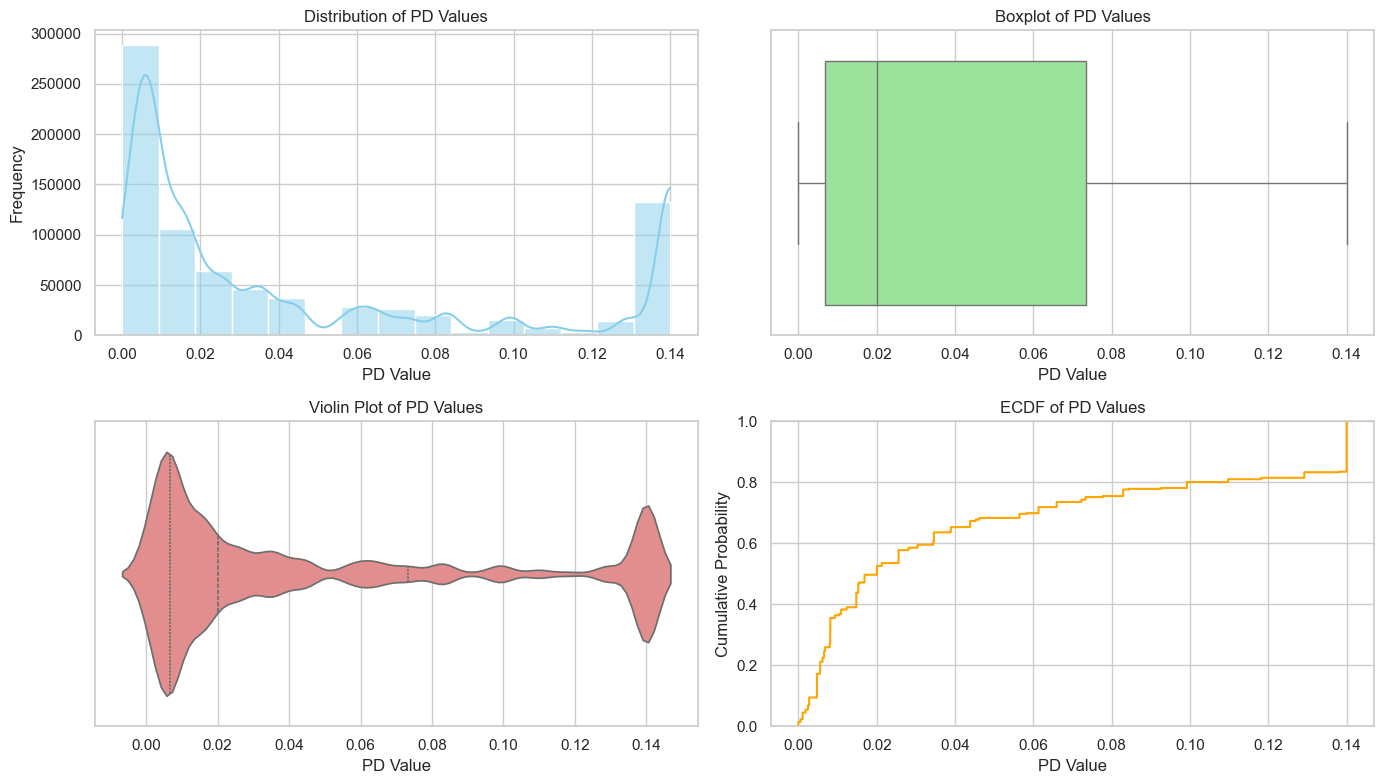

In [29]:
# Sample PD values from your test data
np.random.seed(42)  # For reproducibility
pd_values = np.random.uniform(0, 0.2, 100)  # Example PD values (already normalized by definition)

# Create DataFrame
df_clust = opt_analysis_df[['pd_predics']].rename(columns={'pd_predics': 'PD'})
df_clust['PD'] = df_clust['PD'].clip(upper=0.14)

# Exploratory Data Analysis (EDA)
plt.figure(figsize=(14, 8))

# Histogram to see the distribution of PD values
plt.subplot(2, 2, 1)
sns.histplot(df_clust['PD'], kde=True, bins=15, color='skyblue')
plt.title('Distribution of PD Values')
plt.xlabel('PD Value')
plt.ylabel('Frequency')

# Boxplot to visualize outliers
plt.subplot(2, 2, 2)
sns.boxplot(x=df_clust['PD'], color='lightgreen')
plt.title('Boxplot of PD Values')
plt.xlabel('PD Value')

# Violin Plot to show distribution and density
plt.subplot(2, 2, 3)
sns.violinplot(x=df_clust['PD'], inner='quartile', color='lightcoral')
plt.title('Violin Plot of PD Values')
plt.xlabel('PD Value')

# ECDF to see cumulative distribution
plt.subplot(2, 2, 4)
sns.ecdfplot(df_clust['PD'], color='orange')
plt.title('ECDF of PD Values')
plt.xlabel('PD Value')
plt.ylabel('Cumulative Probability')

plt.tight_layout()
plt.show()

## Business Parameters Setup

In [30]:
# PARAMS
interest_rate=0.38
borrowing_rate=0.27
recovery_rate=0.35

# True Negatives (Correct Non-Defaults Approved) -> Positive Impact
tn_monetry_rate = interest_rate - borrowing_rate
# False Negatives (Bad Loans) -> Negative Impact
fn_monetry_rate = -((1 - recovery_rate) + borrowing_rate)

# True Positives (Correct Defaults Avoided) -> Positive Impact
tp_monetry_rate = 1
# False Positives (Missed Opportunities)
fp_monetry_rate = -1 * (interest_rate - borrowing_rate)

# Business Value Dict.
matrix_dict = {
    'TN': round(tn_monetry_rate,2),
    'FN': round(fn_monetry_rate,2),
    'TP': round(tp_monetry_rate,2),
    'FP': round(fp_monetry_rate,2)
    }

# Break Even Probability of Default
break_even_pd = round((interest_rate - borrowing_rate) / (interest_rate - borrowing_rate + 1 - recovery_rate), 3)

print('Business Value Matrix: ', matrix_dict)
print('Break Even PD: ', break_even_pd)

Business Value Matrix:  {'TN': 0.11, 'FN': -0.92, 'TP': 1, 'FP': -0.11}
Break Even PD:  0.145
